In [1]:
import os
os.chdir("..")


In [2]:
import scipy
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from skin_lesion_cad.features.texture import get_glcm, lbph
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor, LBPDescriptor, DescriptorsTransformer
import pandas as pd
from multiprocessing.dummy import Pool
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score, balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed, parallel_backend
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import random


In [27]:
merged_df_train_vlad = pd.read_pickle('merged_df_train_vlad.pkl')
merged_df_val_vlad = pd.read_pickle('merged_df_val_vlad.pkl')

In [28]:
merged_df_train = pd.read_pickle('merged_df_train.pkl')
merged_df_val = pd.read_pickle('merged_df_val.pkl')


In [55]:
(merged_df_train_vlad.describe()-merged_df_train.describe()).iloc[1,:].sort_values().values


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


array([-4.59661551e-01, -4.53364817e-01, -4.89182729e-02, -4.32811480e-02,
       -4.11840325e-02, -3.98423358e-02, -3.85107775e-02, -3.65857967e-02,
       -3.54048456e-02, -3.49939382e-02, -3.20907660e-02, -3.05682962e-02,
       -3.01313943e-02, -2.79933725e-02, -2.77106428e-02, -2.68958710e-02,
       -2.59770018e-02, -2.48622817e-02, -2.41279816e-02, -2.36997676e-02,
       -2.31234424e-02, -2.14113339e-02, -2.12126179e-02, -1.77784013e-02,
       -1.63518321e-02, -1.62522066e-02, -1.57560845e-02, -1.53106731e-02,
       -1.46624720e-02, -1.39126091e-02, -1.34807609e-02, -1.28858716e-02,
       -1.27043052e-02, -1.25814117e-02, -1.24138924e-02, -1.17856499e-02,
       -1.09004349e-02, -1.07652983e-02, -9.94651666e-03, -7.03172060e-03,
       -6.08633370e-03, -5.84129188e-03, -2.55804801e-03, -2.16724340e-03,
       -1.68903105e-03, -1.30891495e-03, -1.23579800e-03, -1.19418441e-03,
       -9.23151326e-04, -8.51199420e-04, -7.61311087e-04, -3.61887272e-04,
       -1.96772924e-04, -

/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,bow_90,bow_91,bow_92,bow_93,bow_94,bow_95,bow_96,bow_97,bow_98,bow_99
count,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
mean,False,True,False,False,True,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
std,True,False,False,False,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
min,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
25%,True,True,True,False,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
50%,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75%,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
max,True,True,True,True,True,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [21]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
svc = SVC(kernel='rbf', C=1, random_state=42,
          probability=False, class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(5082, 442) (1270, 442)
[[401  37  60]
 [ 82 551  45]
 [ 20  13  61]]
Balanced accuracy 0.8945736170226932
Balanced accuracy 0.7556138065095378
Train kappa 0.7852755551907132
Validation kappa 0.6525267106983319


In [22]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder


In [23]:

X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])


y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


print(X_train_pca.shape, X_test_pca.shape)

svc.fit(X_train_pca, y_train)
y_pred = svc.predict(X_test_pca)
y_pred_train = svc.predict(X_train_pca)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(5082, 150) (1270, 150)
[[395  38  65]
 [ 81 548  49]
 [ 22  11  61]]
Balanced accuracy 0.887048486641916
Balanced accuracy 0.7501228159988224
Train kappa 0.7706697683435108
Validation kappa 0.642018480840963


In [7]:
import xgboost as xgb
from copy import deepcopy


In [16]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


print(X_train_pca.shape, X_test_pca.shape)
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train_pca, y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='balanced_accuracy',
                    param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train_pca, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train_pca)
test_predictions = clf0.predict(X_test_pca)

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

#accuracy scores
accs_train = balanced_accuracy_score(y_train, train_predictions)
accs_test = balanced_accuracy_score(y_test, test_predictions)


kappa_train = cohen_kappa_score(y_train, train_predictions)
kappa_test = cohen_kappa_score(y_test, test_predictions)

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train_kappa': kappa_train,
                         'test_kappa': kappa_test,

                         'best_params': bp}

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(5082, 150) (1270, 150)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[[398  40  60]
 [ 77 555  46]
 [ 20  10  64]]
Balanced accuracy 0.8876778108255493
Balanced accuracy 0.7662106405916139
Train kappa 0.7784174887982479
Validation kappa 0.6582608325711004


In [17]:
bf

NameError: name 'bf' is not defined

In [24]:
clf0.best_params_


{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'hist',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}

In [11]:
bp.update({"gamma":0, "learning_rate":0.2, "max_depth":6, "n_estimators":100, "reg_alpha":0.2, "reg_lambda":0.2})

In [9]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


print(X_train_pca.shape, X_test_pca.shape)
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train_pca, y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='balanced_accuracy',
                    param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train_pca, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train_pca)
test_predictions = clf0.predict(X_test_pca)

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

#accuracy scores
accs_train = balanced_accuracy_score(y_train, train_predictions)
accs_test = balanced_accuracy_score(y_test, test_predictions)


kappa_train = cohen_kappa_score(y_train, train_predictions)
kappa_test = cohen_kappa_score(y_test, test_predictions)

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train_kappa': kappa_train,
                         'test_kappa': kappa_test,

                         'best_params': bp}

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(5082, 150) (1270, 150)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[[398  40  60]
 [ 77 555  46]
 [ 20  10  64]]
Balanced accuracy 0.8876778108255493
Balanced accuracy 0.7662106405916139
Train kappa 0.7784174887982479
Validation kappa 0.6582608325711004


In [19]:
bp

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'hist',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}

In [19]:
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
              'n_estimators': [50, 65, 80, 100, 115, 130, 150],
              'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
              'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]}


In [23]:
import time
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i, grid_key in enumerate(param_grid.keys()):

    #variable for measuring iteration time
    loop_start = time.time()

    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value

    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)

    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params,
                       scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train.values.ravel())

    #results dataframe
    df = pd.DataFrame(clf.cv_results_)

    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    # unseen_predictions = clf.predict(df_test.iloc[:,1:])

    #confusion matrices
    cfm_train = confusion_matrix(y, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

    #accuracy scores
    accs_train = balanced_accuracy_score(y_train, train_predictions)
    accs_test = balanced_accuracy_score(y_test, test_predictions)

    kappa_train = cohen_kappa_score(y_train, train_predictions)
    kappa_test = cohen_kappa_score(y_test, test_predictions)

    #best parameters
    bp = clf.best_params_

    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  #   'cfm_unseen': cfm_unseen,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                  'train_kappa': kappa_train,
                                  'test_kappa': kappa_test,

                                  'best_params': bp}

    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0


Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 432.98437905311584 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 951.6735339164734 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 864.799976348877 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 425.2493658065796 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 651.6802761554718 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 1350.327544927597 seconds


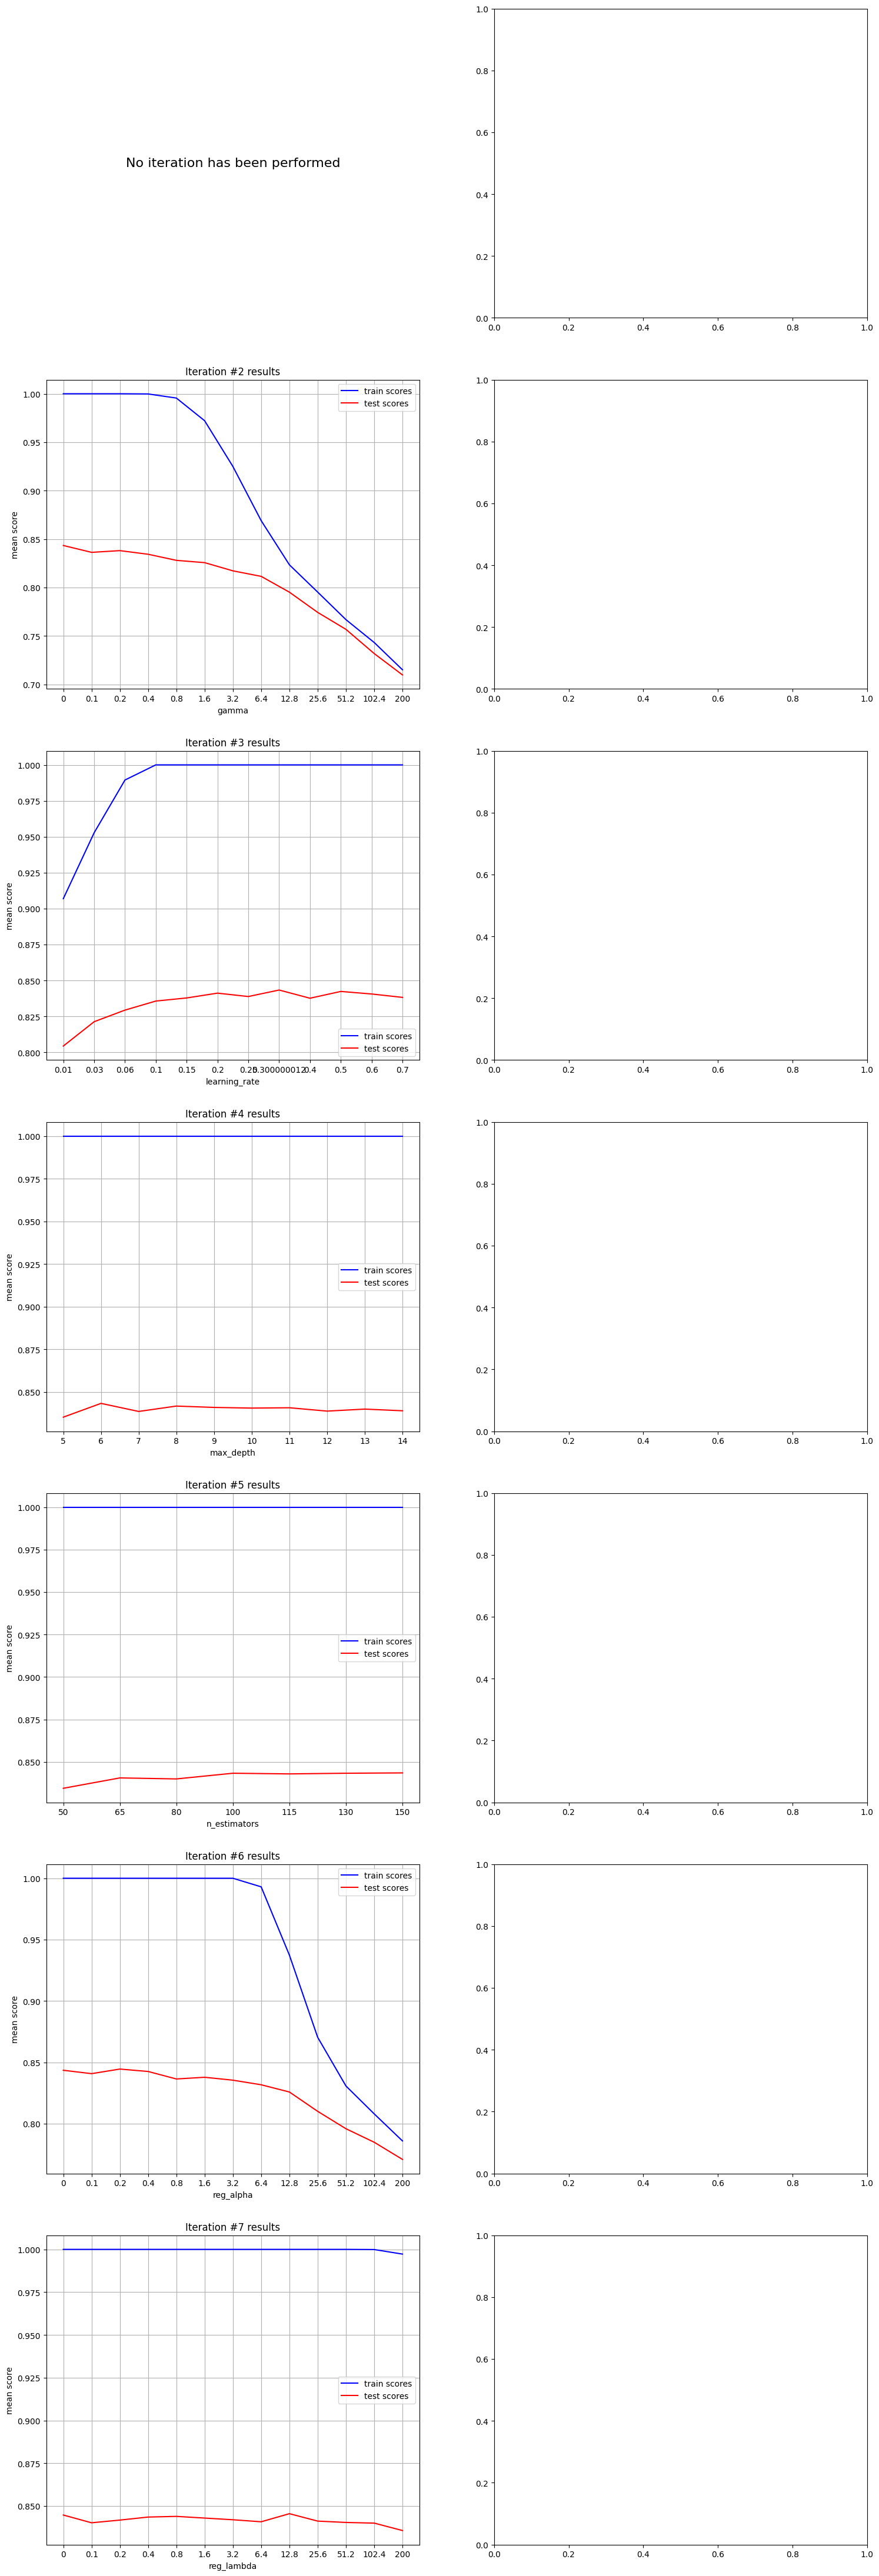

In [32]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())


#creating figure
f, axes = plt.subplots(nrows, 2, figsize=(18, 8*nrows))

#iteratively plotting train/test accuracy scores and test confusion matrix
for i, ax in enumerate(axes):

    #current key of results dictionary
    ckey = list(results_dict.keys())[i]

    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:, 'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:, 'mean_test_score']

        ax[0].plot(x1, label='train scores', color='blue')
        ax[0].plot(x2, label='test scores', color='red')
        ax[0].set_title(f'Iteration #{i+1} results')

        ax[0].set_xticks(list(range(0, len([x[results_dict[ckey]['iterable_parameter']]
                         for x in results_dict[ckey]['cv_results']['params']]))))
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']]
                              for x in results_dict[ckey]['cv_results']['params']]))

        ax[0].grid('major')
        ax[0].legend()
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score')

    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed',
                   fontsize=16, va='center', ha='center')

    #computing variables for specific confusion matrix
    # group_counts = ["{0:0.0f}".format(
    #     value) for value in results_dict[ckey]['cfm_test'].flatten()]
    # group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten(
    # )/np.sum(results_dict[ckey]['cfm_test'])]
    # labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
    #     group_names, group_counts, group_percentages)]
    # labels = np.asarray(labels).reshape(2, 2)

    #plotting confusion matrix
    # sns.heatmap(results_dict[ckey]['cfm_test'],
    #             annot=labels, fmt='', cmap='Blues', ax=ax[1])

plt.show()
